In [17]:
import os
import argparse
import pickle
import cv2
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

import os
from PIL import Image
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import random
import numpy as np
from PIL import ImageEnhance
import torch
import pickle
import io

각종 Transformations


In [45]:
img_transform = transforms.Compose([
            transforms.Resize((480, 480)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            # transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomVerticalFlip(p=0.5),
            # Fix_RandomRotation()
            ])
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
gt_transform = transforms.Compose([
            transforms.Resize((480, 480)),
            transforms.ToTensor()])

In [28]:
def cv_random_flip(img_r, label_r):
    flip_flag = random.randint(0, 1)
    # flip_flag2= random.randint(0,1)
    # left right flip
    print(img_r.size)
    print(label_r.size)
    if flip_flag == 1:
        img_r = img_r.transpose(Image.FLIP_LEFT_RIGHT)
        label_r = label_r.transpose(Image.FLIP_LEFT_RIGHT)

    return img_r, label_r


def randomCrop(img_r, label_r):
    border = 30
    image_width = img_r.size[0]
    image_height = img_r.size[1]
    crop_win_width = np.random.randint(image_width - border, image_width)
    crop_win_height = np.random.randint(image_height - border, image_height)
    random_region = (
        (image_width - crop_win_width) >> 1, (image_height - crop_win_height) >> 1, (image_width + crop_win_width) >> 1,
        (image_height + crop_win_height) >> 1)
    return img_r.crop(random_region), label_r.crop(random_region)


def randomRotation(img_r, label_r):
    mode = Image.BICUBIC
    if random.random() > 0.8:
        random_angle = np.random.randint(-15, 15)
        img_r = img_r.rotate(random_angle, mode)
        label_r = label_r.rotate(random_angle, mode)
    return img_r, label_r


def colorEnhance(image):
    bright_intensity = random.randint(5, 15) / 10.0
    image = ImageEnhance.Brightness(image).enhance(bright_intensity)
    contrast_intensity = random.randint(5, 15) / 10.0
    image = ImageEnhance.Contrast(image).enhance(contrast_intensity)
    color_intensity = random.randint(0, 20) / 10.0
    image = ImageEnhance.Color(image).enhance(color_intensity)
    sharp_intensity = random.randint(0, 30) / 10.0
    image = ImageEnhance.Sharpness(image).enhance(sharp_intensity)
    return image


def randomGaussian(image, mean=0, sigma=0.15):
    def gaussianNoisy(im, mean=mean, sigma=sigma):
        for _i in range(len(im)):
            im[_i] += random.gauss(mean, sigma)
        return im

    img = np.asarray(image)
    width, height = img.shape
    img = gaussianNoisy(img[:].flatten(), mean, sigma)
    img = img.reshape([width, height])
    return Image.fromarray(np.uint8(img))

def randomGaussian1(image, mean=0.1, sigma=0.35):
    def gaussianNoisy(im, mean=mean, sigma=sigma):
        for _i in range(len(im)):
            im[_i] += random.gauss(mean, sigma)
        return im

    img = np.asarray(image)
    width, height = img.shape
    img = gaussianNoisy(img[:].flatten(), mean, sigma)
    img = img.reshape([width, height])
    return Image.fromarray(np.uint8(img))


def randomPeper(img):
    img = np.array(img)
    noiseNum = int(0.0015 * img.shape[0] * img.shape[1])
    for i in range(noiseNum):

        randX = random.randint(0, img.shape[0] - 1)

        randY = random.randint(0, img.shape[1] - 1)

        if random.randint(0, 1) == 0:

            img[randX, randY] = 0

        else:

            img[randX, randY] = 255
    return Image.fromarray(img)

Image

(3, 128, 128)
<class 'numpy.ndarray'>


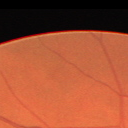

In [85]:
data_path = '/home/kkh/research/seg/FR-UNet/dataset/DRIVE/training_pro_128_16/img_patch_5232.pkl'

with open(file = data_path, mode = 'rb') as file:
    img = pickle.load(file)
print(img.shape)
img = img.transpose(1,2,0)
print(type(img))
# print(img)
img = img*255
img = img.astype(np.uint8)
# print(img.shape)
# # img = img.convert('RGB')
# plt.imshow(img)
# plt.show()

img = Image.fromarray(img)
img.convert('RGB')





display(img)

Apply transforms

Ground truth

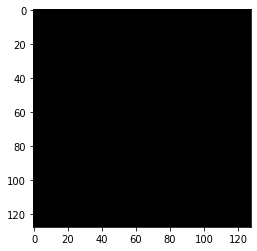

In [87]:
data_path = '/home/kkh/research/seg/FR-UNet/dataset/DRIVE/training_pro_128_16/gt_patch_5219.pkl'

with open(file = data_path, mode = 'rb') as file:
    gt = pickle.load(file)

gt = gt.squeeze()
gt = Image.fromarray(gt)
gt.convert('L')
# print(gt.shape)
# img = img.convert('RGB')
plt.imshow(gt, cmap='gray')
plt.show()

In [69]:
right_image = img
right_gt = gt
right_image, right_gt = cv_random_flip(right_image, right_gt)
right_image, right_gt = randomCrop(right_image, right_gt)
right_image, right_gt  = randomRotation(right_image, right_gt)
right_image = colorEnhance(right_image)

(128, 128)
(128, 128)


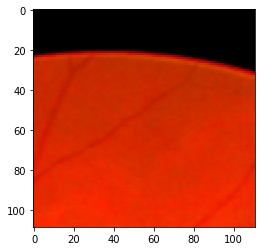

In [70]:
plt.imshow(right_image)

In [71]:
right_image = img_transform(right_image)
right_gt = gt_transform(right_gt)


In [ ]:
# 다시 original image로
# img_retransform = transforms.Compose([
        # transforms.Normalize(mean = [-0.4850/.229, -0.456/0.224, -0.406/0.225], std =[1/0.229, 1/0.224, 1/0.225])])

(480, 480)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


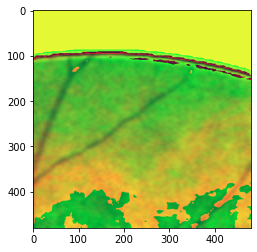

In [82]:



image_arr = right_image.numpy()
image_arr = image_arr * 255
image_arr = image_arr.astype(np.uint8)
gt_arr = right_gt.numpy().squeeze()
print(gt_arr.shape)
gt_arr = gt_arr * 255.0
gt_arr = gt_arr.astype(np.uint8)
print(gt_arr)
plt.imshow(image_arr.transpose(1,2,0))
plt.show()

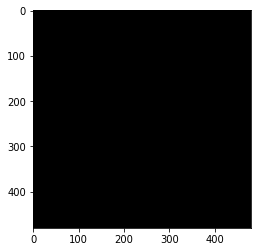

In [83]:
plt.imshow(gt_arr, cmap = 'gray')
plt.show()